In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
import numpy as np

In [3]:
from ML.svr import svr 

In [4]:
# Load the dataset
train_file_path = "./datasets/Train_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
train_data = pd.read_csv(train_file_path)

eval_file_path = "./datasets/Eval_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
eval_data = pd.read_csv(eval_file_path)

In [5]:
#Define levels
levels=5

# Parse relevant columns for all bid and ask levels
bid_columns = [f"bids[{i}].price" for i in range(levels)] + [f"bids[{i}].amount" for i in range(levels)]
ask_columns = [f"asks[{i}].price" for i in range(levels)] + [f"asks[{i}].amount" for i in range(levels)]
feature_columns = bid_columns  + ask_columns
eval_columns=['mark_price','next_mark_price','Price Movement',"actual_direction"]

# Features and target
X_train = train_data[feature_columns]
y_train = train_data['next_mark_price']
# X_test = test_data[feature_columns]
# y_test = test_data["target"]
X_eval = eval_data[feature_columns]

y_eval = eval_data[eval_columns]

In [6]:
svr=svr(X_train,y_train,X_eval)

In [7]:
# if not yet trained
# Measure the execution time of the function

# start_time = time.time()
# svr.train()
# end_time = time.time()
# training_time = (end_time - start_time)* 1000 
# print(f"Training_time(SVR): {training_time:.2f} milliseconds")

In [8]:
# Predict 
# Measure the execution time of the function
start_time = time.time()
svr_Predict_data=pd.DataFrame({"predicted_svr":svr.predict()})
end_time = time.time()
execution_time = (end_time - start_time)* 1000 
print(f"Execution_time(SVR): {execution_time:.2f} milliseconds")

In [ ]:
# combine data tgt
Evaluate_result=pd.concat([y_eval, svr_Predict_data], axis=1)

In [ ]:
Evaluate_result

,mark_price,next_mark_price,Price Movement,actual_direction,predicted_svr
0,58252.67,58252.67,Stable,0.0,58188.420161
1,58252.67,58252.82,Up,1.0,58219.551823
2,58252.82,58252.82,Stable,0.0,58317.431125
3,58252.82,58252.82,Stable,0.0,58276.862403
4,58252.82,58252.46,Down,-1.0,58276.862403
...,...,...,...,...,...
34554,57289.99,57289.99,Stable,0.0,58150.675243
34555,57289.99,57288.26,Down,-1.0,58144.547200
34556,57288.26,57288.26,Stable,0.0,58151.171657
34557,57288.26,57288.26,Stable,0.0,58157.731638


In [ ]:
# Evaluate performance using MSE on evaluation set
mse_svr = mean_squared_error(Evaluate_result['next_mark_price'], Evaluate_result['predicted_svr'])
print(f"Support Vector Regression MSE (Eval Set): {mse_svr:.2f}")

Support Vector Regression MSE (Eval Set): 415550.25


In [ ]:
# Calculate directional accuracy
Evaluate_result.loc[:, "predicted_direction_svr"] = np.sign(Evaluate_result["predicted_svr"] - Evaluate_result["next_mark_price"])
directional_accuracy_svr = (Evaluate_result["actual_direction"] == Evaluate_result["predicted_direction_svr"]).mean()
print(f"Directional Accuracy (Support Vector Regression): {directional_accuracy_svr:.2%}")

Directional Accuracy (Support Vector Regression): 21.51%


In [ ]:
# Tolerance-Based Accuracy
tolerance = 0.0001 * Evaluate_result["next_mark_price"].mean()  # Set tolerance to 0.01% of average price
Evaluate_result.loc[:, "tolerance_svr"] = abs(Evaluate_result["predicted_svr"] - Evaluate_result["next_mark_price"]) <= tolerance

# Calculate tolerance-based accuracy
tolerance_accuracy_svr = Evaluate_result["tolerance_svr"].mean()

print(f"Tolerance-Based Accuracy (Support Vector Regression): {tolerance_accuracy_svr:.2%}")

Tolerance-Based Accuracy (Support Vector Regression): 0.87%


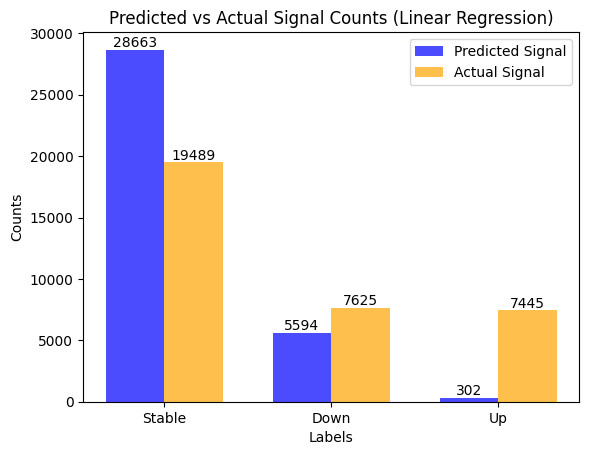

In [ ]:
# Add symbol columns based on comparison with the last mark price
symbol_tolerance = 0.0001 * eval_data["next_mark_price"].mean()  # Adjust as needed
Evaluate_result.loc[:, "symbol_svr"] = None

for i in range(len(Evaluate_result)):

    # Linear Regression symbol logic
    if Evaluate_result["predicted_svr"].iloc[i] > Evaluate_result["mark_price"].iloc[i] + symbol_tolerance:
        Evaluate_result.loc[Evaluate_result.index[i], "symbol_svr"] = "up"
    elif Evaluate_result["predicted_svr"].iloc[i] < Evaluate_result["mark_price"].iloc[i] - symbol_tolerance:
        Evaluate_result.loc[Evaluate_result.index[i], "symbol_svr"] = "down"
    else:
        Evaluate_result.loc[Evaluate_result.index[i], "symbol_svr"] = "stable"

# Visualize symbol distributions
symbol_counts_svr = Evaluate_result["symbol_svr"].value_counts()
Actual_signal_counts = Evaluate_result["Price Movement"].value_counts()

svr_predict_values = symbol_counts_svr.values.tolist()
actual_values = Actual_signal_counts.values.tolist()

labels = Actual_signal_counts.index.tolist()

# Setting the positions and width for the bars
positions = np.arange(len(labels))
bar_width = 0.35


# Create the bar plot
bar1=plt.bar(positions, svr_predict_values, bar_width, label='Predicted Signal', color='b', alpha=0.7)
bar2=plt.bar(positions + bar_width, actual_values, bar_width, label='Actual Signal', color='orange', alpha=0.7)

# Adding labels, title, and legend
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Predicted vs Actual Signal Counts (Linear Regression)')
plt.xticks(positions + bar_width / 2, labels)
plt.legend()

# Displaying the values on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')


plt.show()

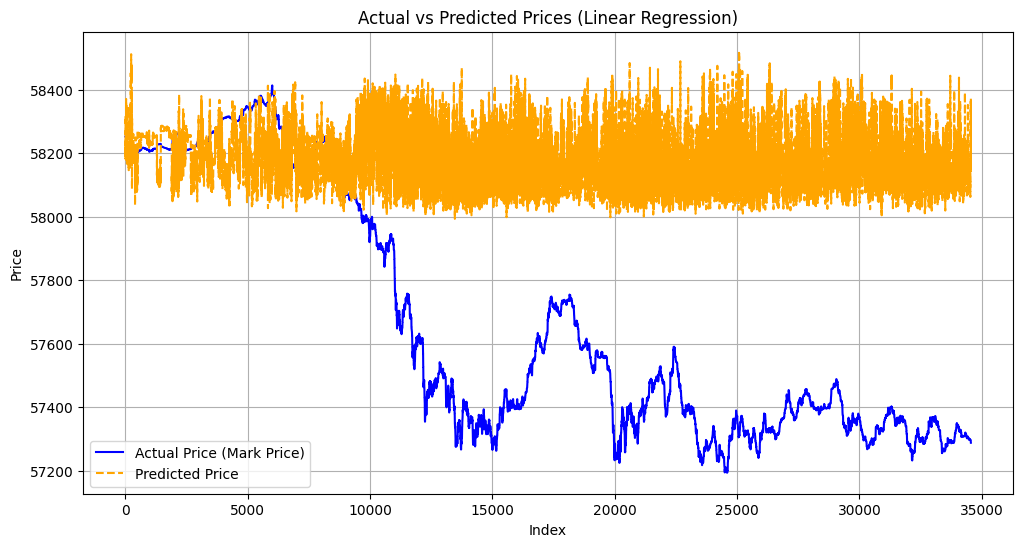

In [ ]:
# Visualize the actual vs. predicted price along with signals
plt.figure(figsize=(12, 6))
plt.plot(Evaluate_result["mark_price"], label="Actual Price (Mark Price)", color="blue")
plt.plot(Evaluate_result["predicted_svr"], label="Predicted Price", color="orange", linestyle="--")
plt.title("Actual vs Predicted Prices (Linear Regression)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()
